# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## test dataset

In [15]:
notebook_login()

In [16]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [17]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [18]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [19]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [20]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [21]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [22]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

### Pretrain merge

In [23]:
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_five')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_three')

pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
pretrain_test_dataset=pretrain_test_dataset.rename_column("sequence", "text")
pretrain_test_dataset=pretrain_test_dataset.rename_column("labels_three_2p", "label")

pretrain_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 700
})

In [25]:
dataset_ccc = concatenate_datasets([dataset_cc,pretrain_test_dataset])
dataset_ccc

Dataset({
    features: ['text', 'label'],
    num_rows: 34748
})

## split 

In [26]:
ds = pretrain_test_dataset.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 140
    })
})

In [27]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 560
})
Dataset({
    features: ['text', 'label'],
    num_rows: 140
})


## label balance

<Axes: ylabel='count'>

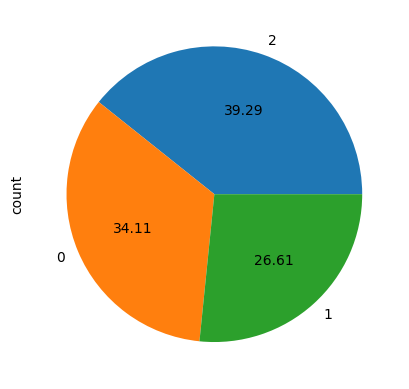

In [28]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

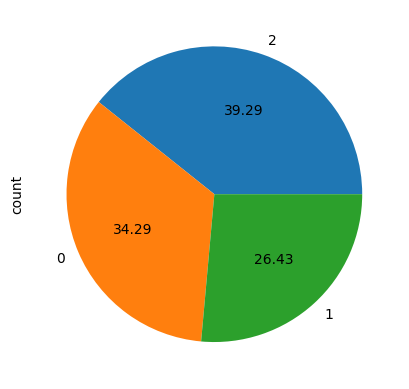

In [29]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

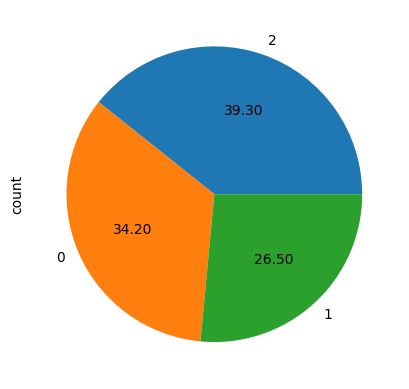

In [30]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

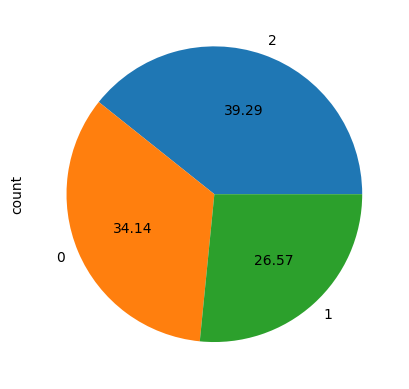

In [31]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.label.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [32]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 560
})
Dataset({
    features: ['text', 'label'],
    num_rows: 140
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 700
})


In [33]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [34]:
model_id="cardiffnlp/twitter-roberta-base-sentiment-latest"



# label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,
#                                                            id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [35]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [36]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [37]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [39]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [40]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [42]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-05 17:08:18,871] A new study created in memory with name: no-name-d99e8857-9441-4c77-a03b-c853215261ee
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 341.9191, 'train_samples_per_second': 4.913, 'train_steps_per_second': 0.088, 'train_loss': 0.5545209248860677, 'epoch': 3.0}


[I 2023-12-05 17:14:10,414] Trial 0 finished with value: 2.8319967728455846 and parameters: {'learning_rate': 1.4213415347517023e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 56}. Best is trial 0 with value: 2.8319967728455846.


{'eval_loss': 0.5857775211334229, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.6996727615922662, 'eval_precision': 0.7030427819720888, 'eval_recall': 0.7007098007098008, 'eval_runtime': 7.0663, 'eval_samples_per_second': 19.812, 'eval_steps_per_second': 2.547, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 143.4561, 'train_samples_per_second': 3.904, 'train_steps_per_second': 0.063, 'train_loss': 1.2345969941880968, 'epoch': 1.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-05 17:16:44,050] Trial 1 finished with value: 0.9606889564336374 and parameters: {'learning_rate': 0.0005449972873643016, 'num_train_epochs': 1, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 2.8319967728455846.


{'eval_loss': 1.0910000801086426, 'eval_accuracy': 0.34285714285714286, 'eval_f1': 0.1702127659574468, 'eval_precision': 0.11428571428571428, 'eval_recall': 0.3333333333333333, 'eval_runtime': 7.7388, 'eval_samples_per_second': 18.091, 'eval_steps_per_second': 2.326, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 139.3781, 'train_samples_per_second': 12.054, 'train_steps_per_second': 0.301, 'train_loss': 1.136267071678525, 'epoch': 3.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-05 17:19:06,209] Trial 2 finished with value: 1.045177045177045 and parameters: {'learning_rate': 0.00035241643844587757, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}. Best is trial 0 with value: 2.8319967728455846.


{'eval_loss': 1.0882561206817627, 'eval_accuracy': 0.39285714285714285, 'eval_f1': 0.18803418803418803, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.8118, 'eval_samples_per_second': 172.457, 'eval_steps_per_second': 22.173, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 342.6856, 'train_samples_per_second': 6.537, 'train_steps_per_second': 0.14, 'train_loss': 0.4547070264816284, 'epoch': 4.0}


[I 2023-12-05 17:24:51,313] Trial 3 finished with value: 2.9389308481413745 and parameters: {'learning_rate': 2.551134805637251e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 48}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6874452233314514, 'eval_accuracy': 0.75, 'eval_f1': 0.7294973544973544, 'eval_precision': 0.7299289891395153, 'eval_recall': 0.7295045045045047, 'eval_runtime': 0.8099, 'eval_samples_per_second': 172.871, 'eval_steps_per_second': 22.226, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 54.4083, 'train_samples_per_second': 51.463, 'train_steps_per_second': 2.206, 'train_loss': 0.40368213653564455, 'epoch': 5.0}


[I 2023-12-05 17:25:48,822] Trial 4 finished with value: 2.9384487716679497 and parameters: {'learning_rate': 1.2341729264593482e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 24}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6509072184562683, 'eval_accuracy': 0.75, 'eval_f1': 0.7294469126660906, 'eval_precision': 0.7294973544973544, 'eval_recall': 0.7295045045045047, 'eval_runtime': 0.8218, 'eval_samples_per_second': 170.358, 'eval_steps_per_second': 21.903, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 95.6608, 'train_samples_per_second': 5.854, 'train_steps_per_second': 0.125, 'train_loss': 1.1175565719604492, 'epoch': 1.0}


[I 2023-12-05 17:27:26,806] Trial 5 finished with value: 2.21712411473096 and parameters: {'learning_rate': 0.0001200009825416913, 'num_train_epochs': 1, 'per_device_train_batch_size': 48}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.8599371910095215, 'eval_accuracy': 0.6285714285714286, 'eval_f1': 0.501622258133213, 'eval_precision': 0.5117598028556932, 'eval_recall': 0.5751706251706251, 'eval_runtime': 0.8118, 'eval_samples_per_second': 172.446, 'eval_steps_per_second': 22.172, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 283.8378, 'train_samples_per_second': 5.919, 'train_steps_per_second': 0.127, 'train_loss': 0.5880525906880697, 'epoch': 3.0}


[I 2023-12-05 17:32:13,249] Trial 6 finished with value: 2.8048136614574903 and parameters: {'learning_rate': 5.740257269011537e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 48}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6069442629814148, 'eval_accuracy': 0.7214285714285714, 'eval_f1': 0.6936862550819001, 'eval_precision': 0.6941658019139859, 'eval_recall': 0.695533033033033, 'eval_runtime': 0.8128, 'eval_samples_per_second': 172.239, 'eval_steps_per_second': 22.145, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 348.1114, 'train_samples_per_second': 4.826, 'train_steps_per_second': 0.086, 'train_loss': 0.6300544738769531, 'epoch': 3.0}


[I 2023-12-05 17:38:04,495] Trial 7 finished with value: 2.8919956282527424 and parameters: {'learning_rate': 5.325964241686084e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 56}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6479860544204712, 'eval_accuracy': 0.7214285714285714, 'eval_f1': 0.7190070552641695, 'eval_precision': 0.7321428571428571, 'eval_recall': 0.7194171444171444, 'eval_runtime': 0.8128, 'eval_samples_per_second': 172.239, 'eval_steps_per_second': 22.145, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 273.5754, 'train_samples_per_second': 10.235, 'train_steps_per_second': 0.256, 'train_loss': 0.5731082916259765, 'epoch': 5.0}


[I 2023-12-05 17:42:41,325] Trial 8 finished with value: 2.7719140505525757 and parameters: {'learning_rate': 3.2464864421172348e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 40}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6162310838699341, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.6846546089700247, 'eval_precision': 0.6864497032728126, 'eval_recall': 0.686524024024024, 'eval_runtime': 0.8168, 'eval_samples_per_second': 171.404, 'eval_steps_per_second': 22.038, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 53.9748, 'train_samples_per_second': 51.876, 'train_steps_per_second': 2.223, 'train_loss': 0.3958038647969564, 'epoch': 5.0}


[I 2023-12-05 17:43:38,426] Trial 9 finished with value: 2.9282773123206907 and parameters: {'learning_rate': 1.3230881518644918e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 24}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6563019156455994, 'eval_accuracy': 0.75, 'eval_f1': 0.7257953555740276, 'eval_precision': 0.7250420168067228, 'eval_recall': 0.7274399399399399, 'eval_runtime': 0.8248, 'eval_samples_per_second': 169.741, 'eval_steps_per_second': 21.824, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 603.3057, 'train_samples_per_second': 3.713, 'train_steps_per_second': 0.053, 'train_loss': 0.6331796050071716, 'epoch': 4.0}


[I 2023-12-05 17:53:52,428] Trial 10 finished with value: 2.821986945678573 and parameters: {'learning_rate': 1.302525321705361e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 72}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6617886424064636, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.6962743803108351, 'eval_precision': 0.6958443854995581, 'eval_recall': 0.7012967512967513, 'eval_runtime': 9.1834, 'eval_samples_per_second': 15.245, 'eval_steps_per_second': 1.96, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 46.9924, 'train_samples_per_second': 47.667, 'train_steps_per_second': 2.043, 'train_loss': 0.37686049938201904, 'epoch': 4.0}


[I 2023-12-05 17:54:42,972] Trial 11 finished with value: 2.9241659101401547 and parameters: {'learning_rate': 4.157292446867344e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 24}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.7541744709014893, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.7270600744284955, 'eval_precision': 0.7278563914622146, 'eval_recall': 0.7263923013923014, 'eval_runtime': 0.8298, 'eval_samples_per_second': 168.72, 'eval_steps_per_second': 21.693, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 139.4927, 'train_samples_per_second': 16.058, 'train_steps_per_second': 0.459, 'train_loss': 0.46445101499557495, 'epoch': 4.0}


[I 2023-12-05 17:57:04,804] Trial 12 finished with value: 2.910443068775553 and parameters: {'learning_rate': 1.7207828702111863e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 36}. Best is trial 3 with value: 2.9389308481413745.


{'eval_loss': 0.6726621389389038, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.7220917221614945, 'eval_precision': 0.7247018204645324, 'eval_recall': 0.7207923832923834, 'eval_runtime': 0.8148, 'eval_samples_per_second': 171.817, 'eval_steps_per_second': 22.091, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 56.5323, 'train_samples_per_second': 49.529, 'train_steps_per_second': 3.096, 'train_loss': 0.3559847586495536, 'epoch': 5.0}


[I 2023-12-05 17:58:03,721] Trial 13 finished with value: 2.9754488039006897 and parameters: {'learning_rate': 8.07765950175059e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}. Best is trial 13 with value: 2.9754488039006897.


{'eval_loss': 1.241179347038269, 'eval_accuracy': 0.75, 'eval_f1': 0.7412525326109227, 'eval_precision': 0.7437819933754893, 'eval_recall': 0.7404142779142778, 'eval_runtime': 0.8218, 'eval_samples_per_second': 170.357, 'eval_steps_per_second': 21.903, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 47.2544, 'train_samples_per_second': 47.403, 'train_steps_per_second': 2.963, 'train_loss': 1.1186636788504465, 'epoch': 4.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-05 17:58:53,304] Trial 14 finished with value: 1.045177045177045 and parameters: {'learning_rate': 0.00012437987746934554, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 13 with value: 2.9754488039006897.


{'eval_loss': 1.0870273113250732, 'eval_accuracy': 0.39285714285714285, 'eval_f1': 0.18803418803418803, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.8218, 'eval_samples_per_second': 170.355, 'eval_steps_per_second': 21.903, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 28.0435, 'train_samples_per_second': 39.938, 'train_steps_per_second': 2.496, 'train_loss': 0.7942094530378069, 'epoch': 2.0}


[I 2023-12-05 17:59:23,681] Trial 15 finished with value: 2.984771526558006 and parameters: {'learning_rate': 9.359061927977144e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 15 with value: 2.984771526558006.


{'eval_loss': 0.665378987789154, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.7424215705066769, 'eval_precision': 0.7434482946496677, 'eval_recall': 0.7417588042588044, 'eval_runtime': 0.8418, 'eval_samples_per_second': 166.317, 'eval_steps_per_second': 21.384, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 27.9481, 'train_samples_per_second': 40.074, 'train_steps_per_second': 2.505, 'train_loss': 1.1767604282924107, 'epoch': 2.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-05 17:59:53,963] Trial 16 finished with value: 1.045177045177045 and parameters: {'learning_rate': 0.0008517294606487425, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 15 with value: 2.984771526558006.


{'eval_loss': 1.1048073768615723, 'eval_accuracy': 0.39285714285714285, 'eval_f1': 0.18803418803418803, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.8408, 'eval_samples_per_second': 166.517, 'eval_steps_per_second': 21.409, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 39.5948, 'train_samples_per_second': 28.287, 'train_steps_per_second': 0.909, 'train_loss': 1.0009956359863281, 'epoch': 2.0}


[I 2023-12-05 18:00:35,864] Trial 17 finished with value: 2.287974288714006 and parameters: {'learning_rate': 0.00011100595391795239, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 15 with value: 2.984771526558006.


{'eval_loss': 0.9110845923423767, 'eval_accuracy': 0.6214285714285714, 'eval_f1': 0.5430170656830128, 'eval_precision': 0.5479280510018215, 'eval_recall': 0.5756006006006006, 'eval_runtime': 0.8198, 'eval_samples_per_second': 170.768, 'eval_steps_per_second': 21.956, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 28.2108, 'train_samples_per_second': 39.701, 'train_steps_per_second': 2.481, 'train_loss': 1.1343024117606026, 'epoch': 2.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-05 18:01:06,976] Trial 18 finished with value: 1.045177045177045 and parameters: {'learning_rate': 0.0002488295833636875, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 15 with value: 2.984771526558006.


{'eval_loss': 1.0859521627426147, 'eval_accuracy': 0.39285714285714285, 'eval_f1': 0.18803418803418803, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.8158, 'eval_samples_per_second': 171.608, 'eval_steps_per_second': 22.064, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 27.2995, 'train_samples_per_second': 41.026, 'train_steps_per_second': 2.564, 'train_loss': 0.6015335083007812, 'epoch': 2.0}


[I 2023-12-05 18:01:36,887] Trial 19 finished with value: 2.956760177592096 and parameters: {'learning_rate': 5.402311988216852e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 15 with value: 2.984771526558006.


{'eval_loss': 0.6225627064704895, 'eval_accuracy': 0.75, 'eval_f1': 0.7353097798259087, 'eval_precision': 0.7378167641325536, 'eval_recall': 0.7336336336336338, 'eval_runtime': 0.8198, 'eval_samples_per_second': 170.768, 'eval_steps_per_second': 21.956, 'epoch': 2.0}


BestRun(run_id='15', objective=2.984771526558006, hyperparameters={'learning_rate': 9.359061927977144e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}, run_summary=None)

# Trainer

In [39]:
training_args = TrainingArguments(
    output_dir='./9-testresults',          # output directory
    learning_rate=9.359061927977144e-05,
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [40]:
train_out

TrainOutput(global_step=70, training_loss=0.6915673392159598, metrics={'train_runtime': 58.3724, 'train_samples_per_second': 19.187, 'train_steps_per_second': 1.199, 'total_flos': 147343513927680.0, 'train_loss': 0.6915673392159598, 'epoch': 2.0})

## Save

In [50]:
trainer.save_model("./my_model")

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./my_model",
    num_labels=train_dataset.features["label"].num_classes,
    ignore_mismatched_sizes=True
)

model.config

RobertaConfig {
  "_name_or_path": "./my_model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [55]:
model.push_to_hub("my_model_SA")
tokenizer.push_to_hub("my_model_SA")

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/HFFErica/my_model_SA/commit/3859329ca3a5af5ae606efcc11d531c5b2b685d8', commit_message='Upload tokenizer', commit_description='', oid='3859329ca3a5af5ae606efcc11d531c5b2b685d8', pr_url=None, pr_revision=None, pr_num=None)

In [57]:
# trainer.push_to_hub()

# Confusion matrix

In [41]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [42]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [43]:
preds_output.metrics

{'test_loss': 0.6468154191970825,
 'test_accuracy': 0.725,
 'test_f1': 0.7068607998877549,
 'test_precision': 0.7063109943501383,
 'test_recall': 0.7088070248436237,
 'test_runtime': 5.3384,
 'test_samples_per_second': 187.324,
 'test_steps_per_second': 11.801}

In [44]:
y_preds = np.argmax(preds_output.predictions, axis=1)

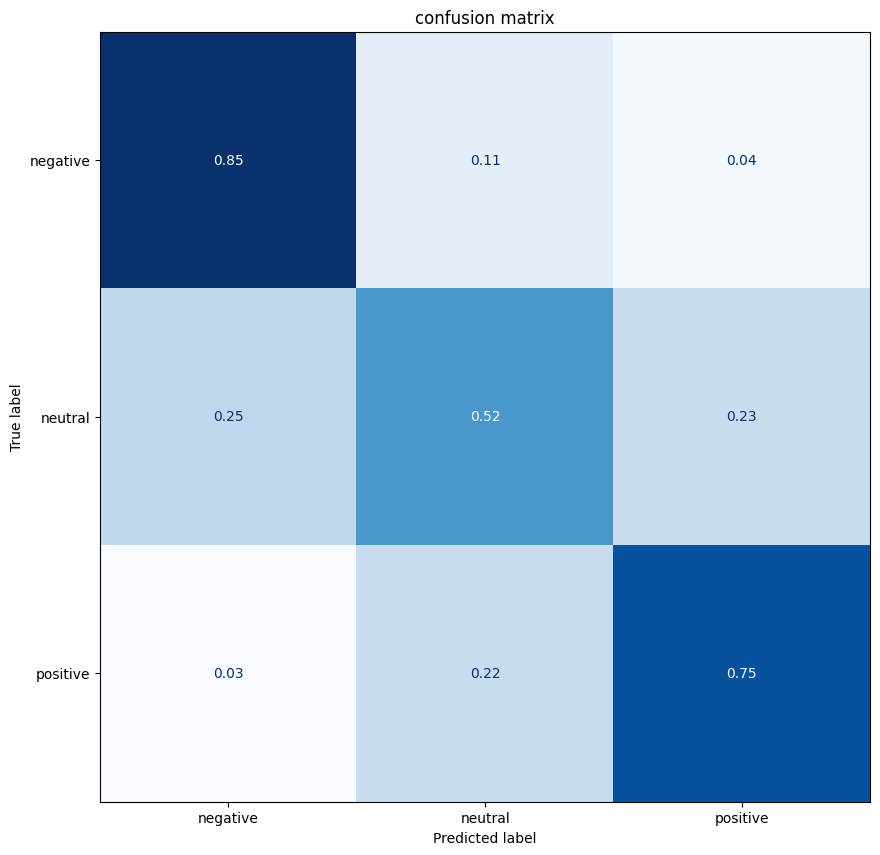

In [45]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [46]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [47]:
preds_output.metrics

{'test_loss': 0.5602618455886841,
 'test_accuracy': 0.7571428571428571,
 'test_f1': 0.7313131313131315,
 'test_precision': 0.7369619112012621,
 'test_recall': 0.7326167076167076,
 'test_runtime': 0.7366,
 'test_samples_per_second': 190.064,
 'test_steps_per_second': 12.218}

In [48]:
y_preds = np.argmax(preds_output.predictions, axis=1)

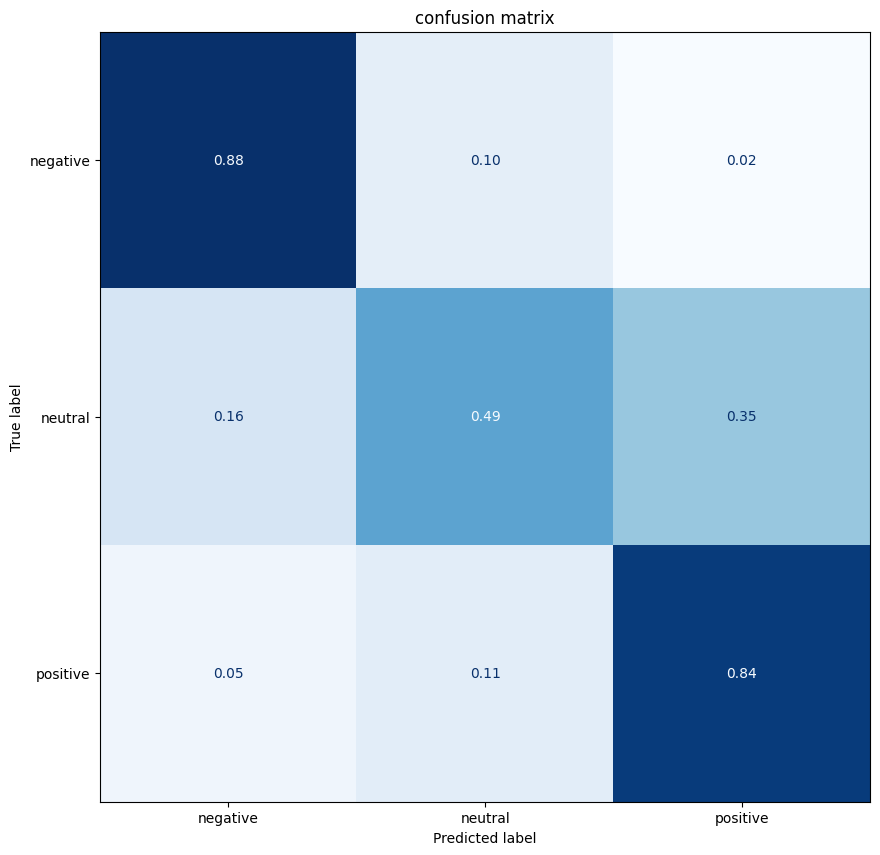

In [49]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

# pipeline

In [58]:
pipe = pipeline("text-classification", model="HFFErica/my_model_SA")

D:\Software\Anaconda3\envs\validation\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\researcher\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [75]:
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

In [68]:
test_examples = test_dataset["sequence"][:1000]
test_examples[2]

"\t\t\t\t\t\t\t\tThere are plenty of reasons to recommend this game, but I'll just mention these: - free exploration- lots of new stuff still being added- freedom to customize your bases and shipsBut most of all I enjoy doing the expeditions."

In [69]:
result = pipe(test_examples[2])
result

[{'label': 'neutral', 'score': 0.49137595295906067}]

In [94]:
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

In [102]:
# df = pd.DataFrame(data=test_dataset.data, columns=test_dataset.feature_names)
# df.head()

df1=test_dataset['sequence']
df2=test_dataset['labels_three_2p']


In [124]:
dataset['content'] = pd.DataFrame(df1)
dataset['label_org'] = pd.DataFrame(df2)

dataset

,labels,input_ids,attention_mask,content,label,label_org
0,tensor(1),"[tensor(0), tensor(7199), tensor(190), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",Not even the Hotel's bombers compete with her ...,1,1
1,tensor(0),"[tensor(0), tensor(1594), tensor(939), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",if i encountered all of this within the first ...,0,0
2,tensor(2),"[tensor(0), tensor(50117), tensor(50117), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",\t\t\t\t\t\t\t\tThere are plenty of reasons to...,2,2
3,tensor(1),"[tensor(0), tensor(100), tensor(64), tensor(42...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","I can run it at 90 frames on ultra, but then i...",1,1
4,tensor(2),"[tensor(0), tensor(1594), tensor(47), tensor(3...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",if you start you experience with theme hospita...,2,2
...,...,...,...,...,...,...
995,tensor(2),"[tensor(0), tensor(118), tensor(657), tensor(4...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",i love this game it is so good if you like r6 ...,2,2
996,tensor(2),"[tensor(0), tensor(50117), tensor(50117), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",\t\t\t\t\t\t\t\tAmazing space exploration expe...,2,2
997,tensor(2),"[tensor(0), tensor(24989), tensor(87), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",Other than that so much fun love the realism,2,2
998,tensor(2),"[tensor(0), tensor(100), tensor(657), tensor(1...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",I love in single player being able to command ...,2,2


In [126]:
df = dataset.drop(columns=['input_ids','label', 'attention_mask'])
df

,labels,content,label_org
0,tensor(1),Not even the Hotel's bombers compete with her ...,1
1,tensor(0),if i encountered all of this within the first ...,0
2,tensor(2),\t\t\t\t\t\t\t\tThere are plenty of reasons to...,2
3,tensor(1),"I can run it at 90 frames on ultra, but then i...",1
4,tensor(2),if you start you experience with theme hospita...,2
...,...,...,...
995,tensor(2),i love this game it is so good if you like r6 ...,2
996,tensor(2),\t\t\t\t\t\t\t\tAmazing space exploration expe...,2
997,tensor(2),Other than that so much fun love the realism,2
998,tensor(2),I love in single player being able to command ...,2


In [115]:
results = pipe(df['content'].values.tolist())

In [116]:
results

[{'label': 'negative', 'score': 0.8929450511932373},
 {'label': 'negative', 'score': 0.9528577327728271},
 {'label': 'neutral', 'score': 0.49137595295906067},
 {'label': 'neutral', 'score': 0.7027553915977478},
 {'label': 'positive', 'score': 0.9588460922241211},
 {'label': 'negative', 'score': 0.9326385259628296},
 {'label': 'positive', 'score': 0.9670273065567017},
 {'label': 'negative', 'score': 0.4927286207675934},
 {'label': 'positive', 'score': 0.5692440271377563},
 {'label': 'neutral', 'score': 0.5410042405128479},
 {'label': 'neutral', 'score': 0.7824918031692505},
 {'label': 'positive', 'score': 0.9285621047019958},
 {'label': 'positive', 'score': 0.8964844942092896},
 {'label': 'neutral', 'score': 0.7212165594100952},
 {'label': 'neutral', 'score': 0.5082650184631348},
 {'label': 'negative', 'score': 0.9288308024406433},
 {'label': 'negative', 'score': 0.716899037361145},
 {'label': 'negative', 'score': 0.8899824619293213},
 {'label': 'negative', 'score': 0.8864833116531372},

In [123]:
name=['label','score']
label_results=pd.DataFrame(columns=name,data=results)
print(label_results)
# label_results.to_csv('./datasets/test_labelled.csv',encoding='utf-8', index=False)

        label     score
0    negative  0.892945
1    negative  0.952858
2     neutral  0.491376
3     neutral  0.702755
4    positive  0.958846
..        ...       ...
995  positive  0.975766
996  positive  0.946128
997  positive  0.959311
998  positive  0.952493
999  positive  0.513783

[1000 rows x 2 columns]


In [118]:
label_results

,label,score
0,negative,0.892945
1,negative,0.952858
2,neutral,0.491376
3,neutral,0.702755
4,positive,0.958846
...,...,...
995,positive,0.975766
996,positive,0.946128
997,positive,0.959311
998,positive,0.952493


In [132]:
mergedf = pd.concat([df, label_results], axis=1)
mergedf

,labels,content,label_org,label,score
0,tensor(1),Not even the Hotel's bombers compete with her ...,1,negative,0.892945
1,tensor(0),if i encountered all of this within the first ...,0,negative,0.952858
2,tensor(2),\t\t\t\t\t\t\t\tThere are plenty of reasons to...,2,neutral,0.491376
3,tensor(1),"I can run it at 90 frames on ultra, but then i...",1,neutral,0.702755
4,tensor(2),if you start you experience with theme hospita...,2,positive,0.958846
...,...,...,...,...,...
995,tensor(2),i love this game it is so good if you like r6 ...,2,positive,0.975766
996,tensor(2),\t\t\t\t\t\t\t\tAmazing space exploration expe...,2,positive,0.946128
997,tensor(2),Other than that so much fun love the realism,2,positive,0.959311
998,tensor(2),I love in single player being able to command ...,2,positive,0.952493


In [134]:
mergedf.to_csv('./datasets/labelled_compare.csv',encoding='utf-8', index=False)

In [87]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>